In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import random
import pickle


from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.decomposition import PCA

from sklearn.metrics import r2_score

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size' : 14})

In [4]:
# Calculate the minimum boxplot
def min_boxplot(sing):
    """
    This function calculates the minimum boundary of the boxplot distribution
    """
    q3 = np.quantile(sing, 0.75)
    q1 = np.quantile(sing, 0.25)
    IQR = q3 - q1
    boxplot_min = q1 - 1.5*IQR
    
    return boxplot_min

In [5]:
# Calculate the maximum boxplot
def max_boxplot(sing):
    """
    This function calculates the maximum boundary of the boxplot distribution
    """
    q3 = np.quantile(sing, 0.75)
    q1 = np.quantile(sing, 0.25)
    IQR = q3 - q1
    boxplot_max = q3 + 1.5*IQR
    
    return boxplot_max

In [6]:
# Let's create a function to display the coefficient of determination on the graph.
def evalute_preds(train_true_values, train_preds_values, test_true_values, test_preds_values):
    """
    Displays the coefficient of determination on the test and training samples and displays it on the graph.
    """
    print('Train R2:\t' + str(round(r2_score(train_true_values, train_preds_values), 3)))
    print('Test R2:\t' + str(round(r2_score(test_true_values, test_preds_values), 3)))
    
    plt.figure(figsize=(10, 10), )
    plt.subplots_adjust(wspace=0.4)
    
    plt.subplot(121)
    plt.scatter(x=train_preds_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    plt.scatter(x=test_preds_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

In [7]:
# Creating constans fot training and test samples
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Описание датасета
* __Id__ - Идентификационный номер квартиры
* __Districtld__ - Идентификационный номер района
* __Rooms__ - количество комнат
* __Square___ - общая площадь
* __LifeSquare__ - жилая площадь
* __KitchenSquare__ - площадь кухни
* __Floor__ - этаж
* __HouseFloor__ - количество этажей в доме
* __HouseYear__ - год постройки
* __Ecolgy_1, Ecology_2, Ecology_3__ - экологические показатели месности
* __Social_1, Social_2, Social_3__ - социальные показатели местности
* __Healtcare_1, Healtcare_2__ - показатели местности, связанные с охраной здоровья
* __Shops_1, Shpos_2__ - показатели, связанные с наличием магазинов, торговых центров
* __Price__ - цены на квартиры

In [9]:
# Loading the feature space
X = pd.read_csv(TRAIN_DATASET_PATH)
X

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [10]:
# Loading the feature space
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [11]:
X_2 = X.copy()

In [12]:
# Selecting a target variable
y = X['Price']
y

0       184966.930730
1       300009.450063
2       220925.908524
3       175616.227217
4       150226.531644
            ...      
9995    196684.316040
9996    189050.289571
9997    159143.805370
9998    181595.339808
9999    218714.077615
Name: Price, Length: 10000, dtype: float64

Text(0, 0.5, 'Count')

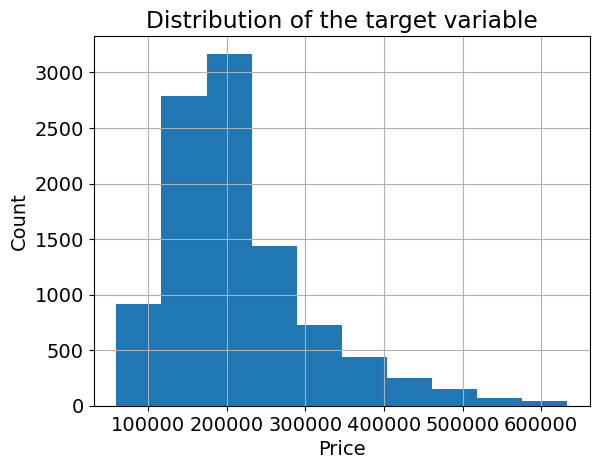

In [13]:
# Distribution of the target variable
y.hist()
plt.title('Distribution of the target variable')
plt.xlabel('Price')
plt.ylabel('Count')

The distribution is lognormal.

<Axes: >

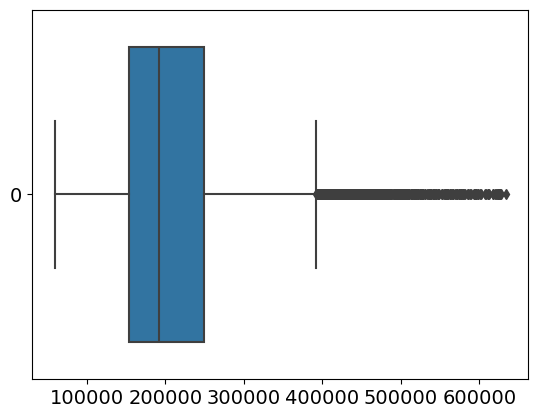

In [15]:
# Let's look at the outliers of the target variable
sns.boxplot(y, orient="h")

Boxplot clearly shows outliers when the cost of an apartment is above 390_000 thousand. To normalize the distribution, the outliers will be replaced by the median.

In [17]:
# Replacing the outliers with the median.
y[y > max_boxplot(y)] = y.median()

<Axes: >

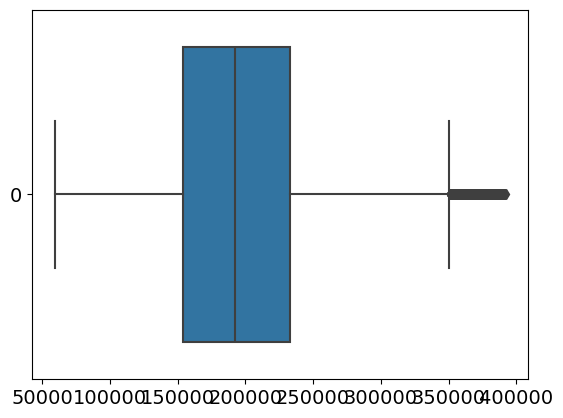

In [18]:
# The boxplot distribution of the target variable after outlier processing.
sns.boxplot(y, orient="h")

In [19]:
# Let's check the empty values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

There are no values in this dataset. These are the signs: Life Square and Healthcare_1. The Health_1 attribute will be deleted because almost 50% of the data is missing. And the empty values of the LifeSquare attribute will be replaced by the median. Because it is less affected by emissions.

Let's remove the target variable from the feature space. We will remove the non-informative Id attribute, as well as the Healthcare_1 attribute.

In [22]:
# Replace the empty values in the LifeSquare attributes with the median
LifeSquare = X['Square'] - X['KitchenSquare']
X['LifeSquare'].fillna(LifeSquare, inplace=True)

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'DistrictId'}>,
        <Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Square'}>],
       [<Axes: title={'center': 'LifeSquare'}>,
        <Axes: title={'center': 'KitchenSquare'}>,
        <Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'HouseFloor'}>],
       [<Axes: title={'center': 'HouseYear'}>,
        <Axes: title={'center': 'Ecology_1'}>,
        <Axes: title={'center': 'Social_1'}>,
        <Axes: title={'center': 'Social_2'}>],
       [<Axes: title={'center': 'Social_3'}>,
        <Axes: title={'center': 'Healthcare_1'}>,
        <Axes: title={'center': 'Helthcare_2'}>,
        <Axes: title={'center': 'Shops_1'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

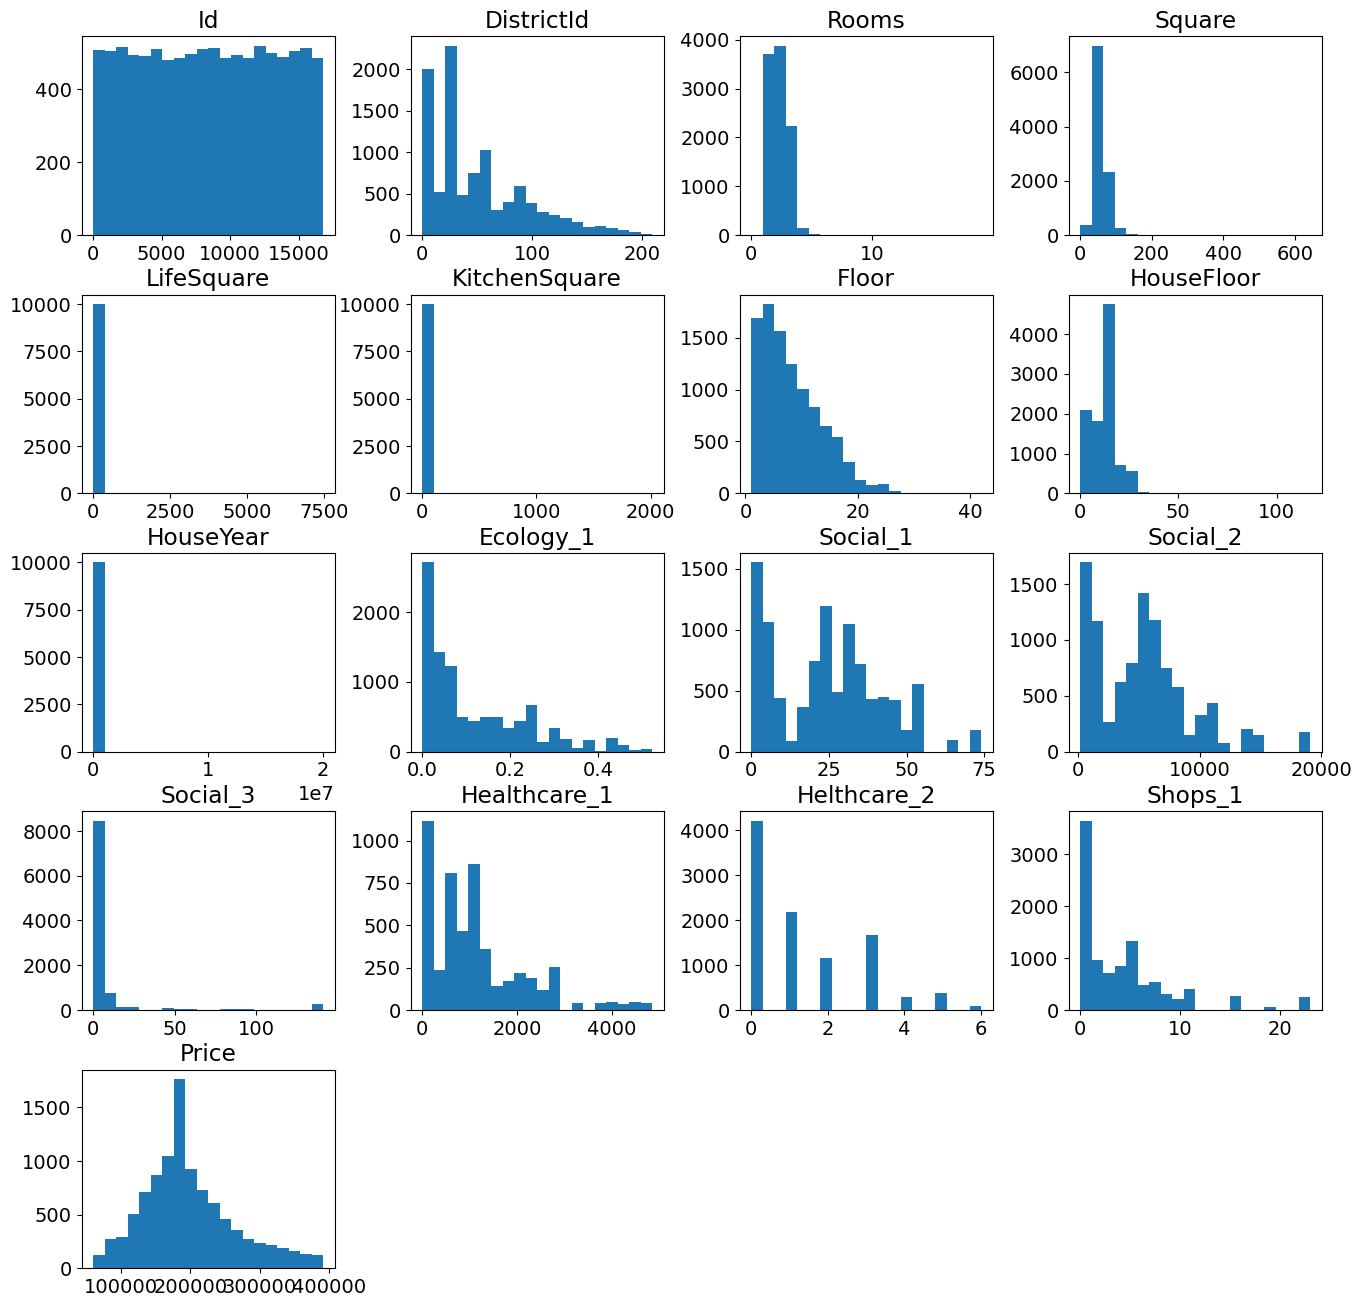

In [23]:
# Let's look at the distributions of all the signs
X.hist(figsize=(16, 16), bins=20, grid=False)

In [24]:
# Let's look at the descriptive statistics
X.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,41.799474,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,198080.255743
std,4859.01902,43.587592,0.839512,21.058732,77.823543,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,66660.709631
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.494155,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,37.040829,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192265.804075
75%,12592.50000,75.000000,2.000000,65.900625,49.823229,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,232579.264777
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,391982.648184


As we can see from the descriptive statistics. The minima and maxima of the signs: Rooms, Square, Life Square, KitchenSquare, House Floor do not correspond to reality, these signs will be reduced to absolute values.

### Pricessing of the Rooms attribute

In [27]:
# Let's look at all the values of the rooms
X['Rooms'].value_counts()

Rooms
2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: count, dtype: int64

In [28]:
# Replace the values of rooms that are greater than 6. Replace with the median.
X['Rooms'][X['Rooms'] >= 6] = X['Rooms'].median()

<Axes: >

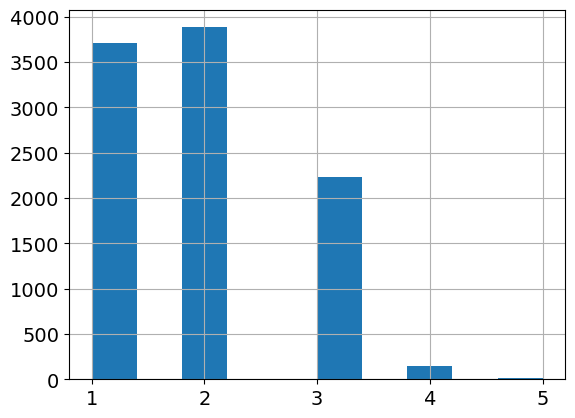

In [29]:
# Replace the zero value of the number of rooms with 1
X['Rooms'][X['Rooms'] == 0] = 1
X['Rooms'].hist()

In [30]:
# Output of the processed attribute
X['Rooms'].value_counts()

Rooms
2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: count, dtype: int64

### Pricessing of the Square attribute

In [32]:
X.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.887600,56.315775,41.799474,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,198080.255743
std,4859.01902,43.587592,0.811438,21.058732,77.823543,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,66660.709631
min,0.00000,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.494155,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,37.040829,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192265.804075
75%,12592.50000,75.000000,2.000000,65.900625,49.823229,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,232579.264777
max,16798.00000,209.000000,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,391982.648184


In [33]:
# Let's process the maximum and minimum emissions of the Square attribute
X['Square'][X['Square'] < min_boxplot(X['Square'])] = X['Square'].median()
X['Square'][X['Square'] > max_boxplot(X['Square'])] = X['Square'].median()

(array([  14.,  170., 1746., 2578., 1747., 1634.,  699.,  947.,  326.,
         139.]),
 array([ 13.78486476,  22.6120751 ,  31.43928545,  40.26649579,
         49.09370613,  57.92091648,  66.74812682,  75.57533716,
         84.4025475 ,  93.22975785, 102.05696819]),
 <BarContainer object of 10 artists>)

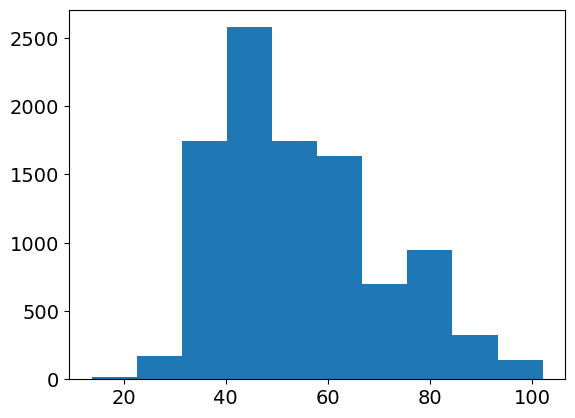

In [34]:
# Let's build a histogram after processing the data
plt.hist(X['Square'])

As we can see, the histogram has taken on a more normalized appearance.

### Pricessing of the KitchenSquare attribute

<Axes: >

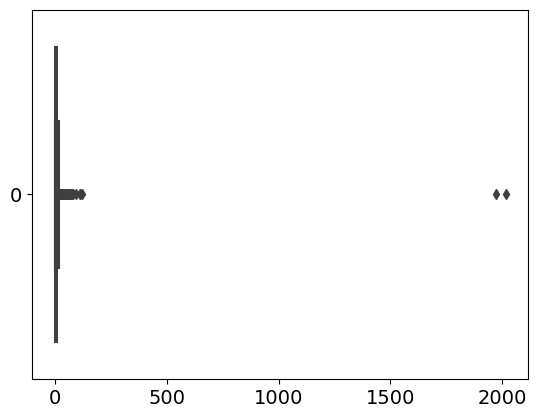

In [37]:
# Let's build a boxplot to determine outliers
sns.boxplot(X['KitchenSquare'], orient='h')

In [38]:
# Let's find the boundaries of the boxplot
max_boxplot(X['KitchenSquare']), min_boxplot(X['KitchenSquare'])

(21.0, -11.0)

In [39]:
# Let's process the maximum and minimum emissions of the KitchenSquare attribute
X['KitchenSquare'][X['KitchenSquare'] < 4] = X.KitchenSquare.median() 
X['KitchenSquare'][X['KitchenSquare'] > max_boxplot(X['KitchenSquare'])] = X['KitchenSquare'].median()

The value of 4 "square meters" was taken from google sources.

<Axes: >

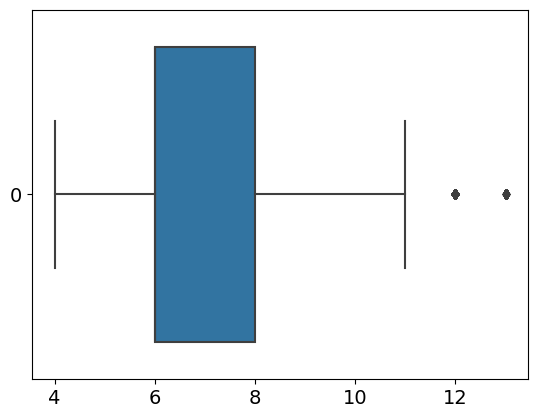

In [41]:
# Let's build a boxplot after processing the data
sns.boxplot(X['KitchenSquare'], orient='h')

In [42]:
X.KitchenSquare.value_counts()

KitchenSquare
6.0     4410
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: count, dtype: int64

This graph shows that there are no emissions

### Pricessing of the LifeSquare attribute

<Axes: >

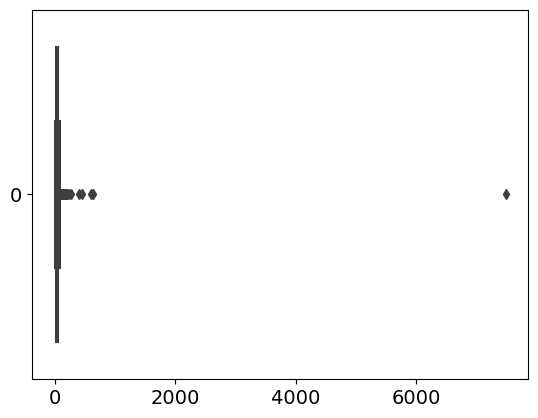

In [45]:
# Let's build a boxplot to determine outliers
sns.boxplot(X['LifeSquare'], orient='h')

In [46]:
# Let's find the boundaries of the boxplot
max_boxplot(X['LifeSquare']), min_boxplot(X['LifeSquare'])

(86.31683976835826, -10.999455527123153)

In [47]:
# Let's process the maximum and minimum emissions of the LifeSquare attribute
X['LifeSquare'][X['LifeSquare'] > max_boxplot(X['LifeSquare'])] = X['LifeSquare'].median()
X['LifeSquare'][X['LifeSquare'] < min_boxplot(X['LifeSquare'])] = X['LifeSquare'].median()

<Axes: >

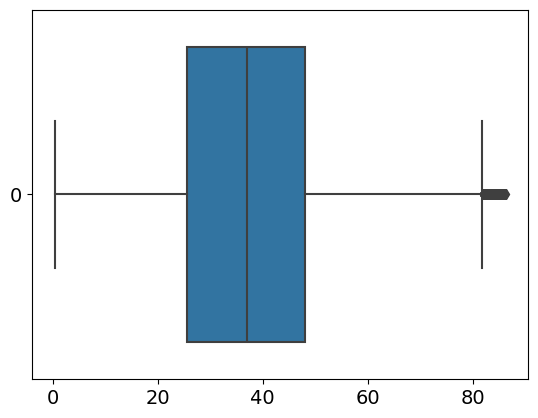

In [48]:
# Let's build a boxplot after processing the data
sns.boxplot(X['LifeSquare'], orient='h')

### Pricessing of the Floor and Houseloor attribute

In [50]:
# Let's look at the values of the Floor attribute
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [51]:
# Let's look at the values of the HouseFloor attribute
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

<Axes: >

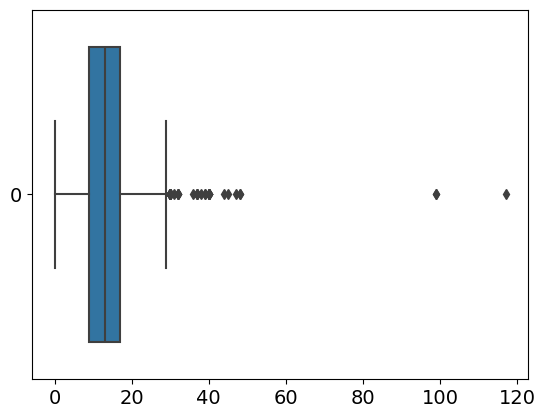

In [52]:
# Посмотрим на выбросы принаков Floor 
sns.boxplot(X['HouseFloor'], orient='h')

<Axes: >

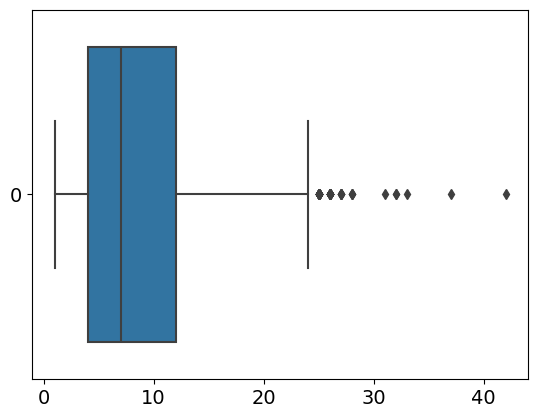

In [53]:
# Посмотрим на выбросы принаков HouseFloor
sns.boxplot(X['Floor'], orient='h')

In [54]:
# Let's process the maximum and minimum emissions of the HouseFloor attribute
X['HouseFloor'][(X['HouseFloor'] >= max_boxplot(X['HouseFloor'])) | (X['HouseFloor'] == 0)] = X['HouseFloor'].median()

<Axes: >

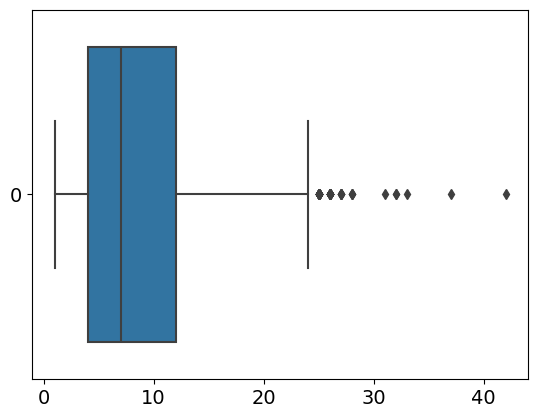

In [55]:
# Let's look at the Floor after processing the emissions
sns.boxplot(X['Floor'], orient='h')

<Axes: >

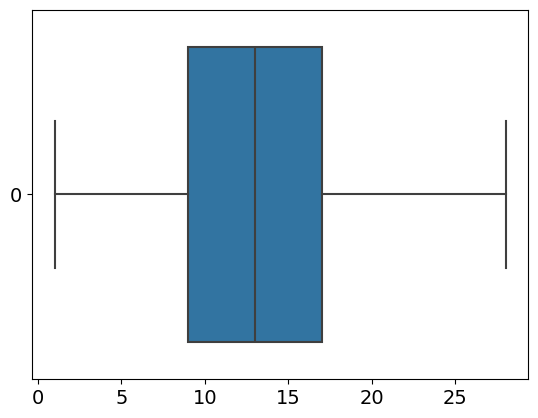

In [56]:
# Let's look at the HouseFloor after processing the emissions
sns.boxplot(X['HouseFloor'], orient='h')

In [57]:
# Let's create conditions for selecting a floor.
condition_of_the_stage = (X['Floor'] > X['HouseFloor']) | (X['HouseFloor'] == 0)

In [58]:
# Let's replace the floor number in houses where the number of storeys of the house is less than the floor number
X.loc[condition_of_the_stage, 'Floor'] = X.loc[condition_of_the_stage, 'HouseFloor'].apply(lambda x: random.randint(1, x))
X

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,2,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,46.939008,6.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


### Pricessing of the HouseYear attribute

In [60]:
# Let's look at the values of the HouseYear attribute
X['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In this case, there are abnormal values: 20052011, 4968, replace them with the median.

In [62]:
# Converting the values of the HouseYear attribute
X['HouseYear'][X['HouseYear'] >  datetime.now().year] =  datetime.now().year
X['HouseYear'].sort_values(ascending=False)

4189    2024
1497    2024
5701    2020
2493    2020
1499    2020
        ... 
7611    1916
910     1914
2656    1912
5111    1912
9317    1910
Name: HouseYear, Length: 10000, dtype: int64

### Pricessing of the Exology_2, Ecology_3, Shops_2 attribute

In [64]:
# Exology_2, Ecology_3, Shops_2
X['Ecology_2']=X['Ecology_2'].replace({'A':0, 'B':1})
X['Ecology_3']=X['Ecology_3'].replace({'A':0, 'B':1})
X['Shops_2']=X['Shops_2'].replace({'A':0, 'B':1})
     

In [65]:
# Let's create a copy of the dataset to build a heat map and identify strong correlations
X_copy = X.copy()

In [66]:
# Deleting selected features.
X.drop(columns=['Id','Price', 'Healthcare_1'], axis=1, inplace=True)
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,0,11,1
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,1,16,1
2,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,1,1,34,7759,0,1,3,1
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,0,5,1
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,2,5.0,1968,0.135650,1,1,46,7960,6,3,11,1
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,1,1,30,5562,0,0,5,0
9997,27,1.0,47.939008,46.939008,6.0,12,16.0,2015,0.072158,1,1,2,629,1,0,0,0
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,1,0,30,5048,9,2,5,1


After processing the validation, validation, and test samples. In the test sample, there were 2 more signs because the labels were not removed: Id and Healthcare_1.

In [68]:
# Удалим признаки Id, Healthcare_1.
X_copy.drop(columns=['Id', 'Healthcare_1'], axis=1, inplace=True)

### Pricessing of the Social_3 attribute

In [70]:
# Let's look at the values of the Social_3 attribute
X['Social_3'].sort_values(ascending=False)

5818    141
9145    141
5862    141
4766    141
4764    141
       ... 
5117      0
5121      0
5136      0
5139      0
9999      0
Name: Social_3, Length: 10000, dtype: int64

In [71]:
# Let's process the emissions
X['Social_3'][X['Social_3'] > max_boxplot(X['Social_3'])] = X['Social_3'].median()

<Axes: >

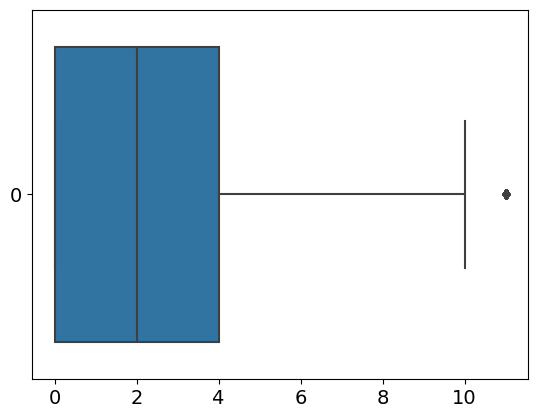

In [72]:
sns.boxplot(X['Social_3'], orient='h')

<Axes: >

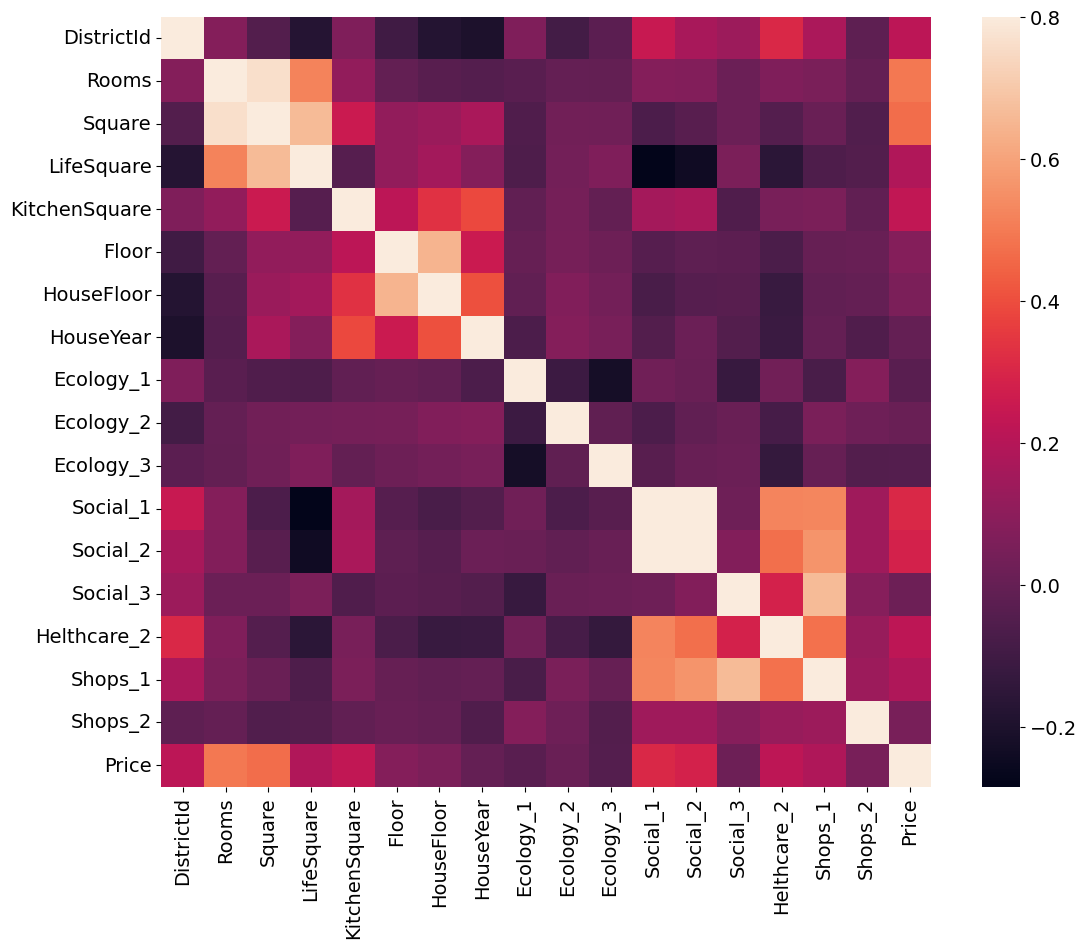

In [73]:
# Correlation matrix
corrmat = X_copy.corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat, vmax=.8, square=True)

Signs with strong correlation: Rooms and Square, Social_1 and Social_2. These four attributes will be converted into two different attributes.

Text(0, 0.5, 'Rooms')

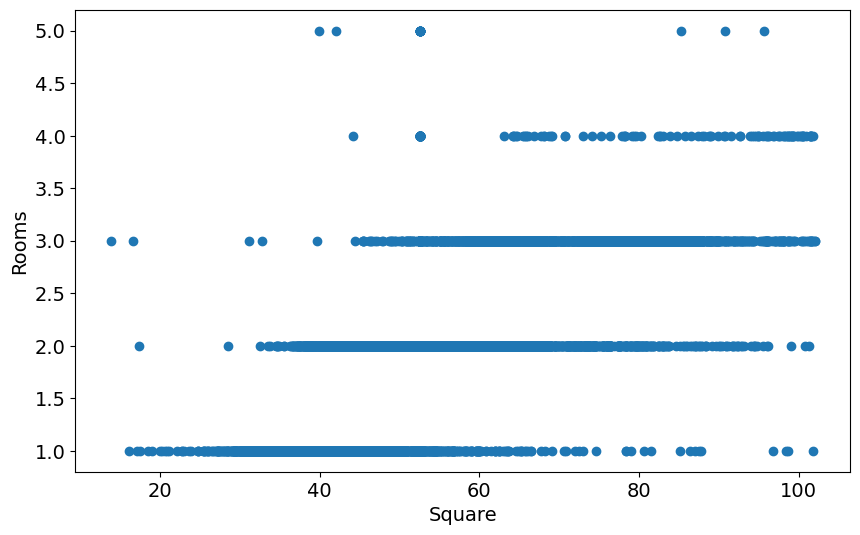

In [75]:
# Building components from Rooms and Square attributes.
X_small = X[['Rooms', 'Square']]

pca = PCA(n_components=1, random_state=123)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.Square,X_small.Rooms)
plt.xlabel('Square')
plt.ylabel('Rooms')

In [76]:
X_small

,Rooms,Square,component_1
0,2.0,47.981561,-6.663724
1,3.0,65.683640,11.063921
2,2.0,44.947953,-9.695011
3,2.0,53.352981,-1.296413
4,1.0,39.649192,-15.028828
...,...,...,...
9995,2.0,50.401785,-4.245352
9996,1.0,41.521546,-13.157907
9997,1.0,47.939008,-6.745355
9998,2.0,43.602562,-11.039373


This component will not learn when training the model. Because the data is divided into classes.

Text(0, 0.5, 'Social_2')

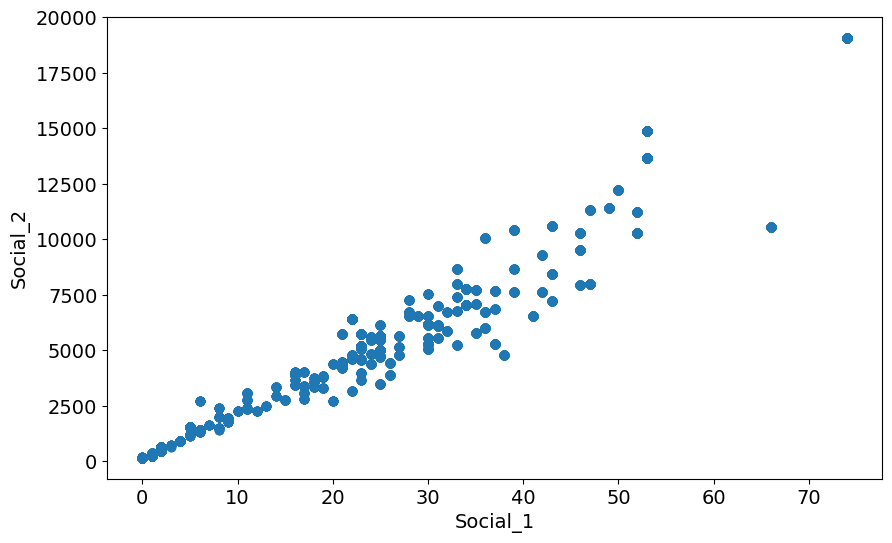

In [78]:
# Building components from  Social_1 and Social_2 attributes.
X_small_2 = X[['Social_1', 'Social_2']]

pca = PCA(n_components=1, random_state=123)
X_small_2['component_2'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small_2.Social_1,X_small_2.Social_2)
plt.xlabel('Social_1')
plt.ylabel('Social_2')

In [79]:
X_small_2.head()

,Social_1,Social_2,component_2
0,33,7976,-9.423929
1,46,10309,15.646747
2,34,7759,-13.710816
3,23,5735,-1.833405
4,35,5776,-21.253973


In [80]:
# Let's create a class for processing dataset attributes
class ProcessingDataset():
    """
    Обработка тестовой и обущающей выборки
    """

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.binary_to_numbers=None
        self.LifeSquare_nan=None
        self.condition_of_the_stage=None
        self.locs=None
        self.y=None
        # self.fillna_=None
       
        

    def fit(self, X, y=None):
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = X.median()
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.condition_of_the_stage = (X['Floor'] > X['HouseFloor']) | (X['HouseFloor'] == 0)
        self.LifeSquare_nan = X['Square'] - X['KitchenSquare']
        self.locs = X.loc()
        if 'Price' in X.columns:
            self.y = X['Price']
        self.q3 = np.quantile(X, 0.75)
        self.q1 = np.quantile(X, 0.25)
        self.IQR = self.q3 - self.q1
        self.boxplot_max = self.q3 + 1.5*self.IQR
        self.boxplot_min = self.q1 - 1.5*self.IQR
        # self.fillna_ = X.fillna(self.LifeSquare_nan, inplace=True)
          
    def transform(self, X, y=None):
        """Трансформация данных"""


        if X is test_df:
            for i in ['Ecology_2', 'Ecology_3', 'Shops_2']:
                X[i] = X[i].map(self.binary_to_numbers)
               
            
        # Selecting a target variable
        if self.y is not None:
           
            # Replacing the outliers with the median.
            self.y[self.y > self.boxplot_max] = self.y.median()
            # Iterate through the columns to check if they exist
            for column in ['Id', 'Price', 'Healthcare_1']:
                if column in X.columns:
                    X.drop(columns=column, axis=1, inplace=True)
        else:
            # Deleting selected features.
            X.drop(columns=['Id', 'Healthcare_1'], axis=1, inplace=True)
        
      
      
        # Replace the empty values in the LifeSquare attributes with the median
        X['LifeSquare'].fillna(self.LifeSquare_nan, inplace=True)
        X['LifeSquare'] = X['LifeSquare'].fillna(method='ffill')
        # X['LifeSquare'][X['LifeSquare'] == 'nan'] = self.medians['LifeSquare']

             
        # Rooms

        X['Rooms'][X['Rooms'] >= 6] = self.medians['Rooms']
        X['Rooms'][X['Rooms'] == 0] = 1


        # KitchenSquare

        X['KitchenSquare'][X['KitchenSquare'] < 4] = self.medians['KitchenSquare']
        X['KitchenSquare'][X['KitchenSquare'] > self.boxplot_max] = self.medians['KitchenSquare']

        # Square

        X['Square'][X['Square'] < self.boxplot_min] = self.medians['Square']
        X['Square'][X['Square'] > self.boxplot_max] = self.medians['Square']

        # LifeSquare
        
        X['LifeSquare'][X['LifeSquare'] > self.boxplot_max] = self.medians['LifeSquare']
        X['LifeSquare'][X['LifeSquare'] < self.boxplot_min] = self.medians['LifeSquare']

        # Floor and Houseloor

        X['HouseFloor'][(X['HouseFloor'] >= self.boxplot_max) | (X['HouseFloor'] == 0)] = self.medians['HouseFloor']
        
        self.locs[self.condition_of_the_stage, 'Floor'] = self.locs[self.condition_of_the_stage, 'HouseFloor'].apply(lambda x: random.randint(1, int(x)))

        # HouseYear

        X['HouseYear'][X['HouseYear'] > datetime.now().year] = datetime.now().year
        X['HouseYear'].sort_values(ascending=False)

        # Let's process the emissions
        X['Social_3'][X['Social_3'] > self.boxplot_max] = self.medians['Social_3']
       
        # # Building components from  Social_1 and Social_2 attributes.
        # X_small_2 = X[['Social_1', 'Social_2']]
        
        # pca = PCA(n_components=1, random_state=123)                                                       # После создания компонеты метрика R2 уменшила 
        #                                                                                                     # свой показатель. Предположение из-за маленького
        # # pca.fit(X_small_2                                                                                 # количества данных                                                                
        # X_small_2['component_2'] = pca.fit_transform(X_small_2)

        
        # # Add the component to the Main Dataset and remove the converted attributes
        # X = pd.concat([X, X_small_2['component_2']], axis=1)
        
        # X.drop(columns=['Social_1','Social_2'], axis=1, inplace=True)
                       
        return  X

In [81]:
# Let's divide the sample into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_copy, y, test_size=.2, shuffle=True, random_state=123)

In [82]:
X_train.shape, X_valid.shape, test_df.shape

((8000, 18), (2000, 18), (5000, 19))

In [83]:
# Трансформируем тестовую, тренеровочную и валидационнуб выборку
preprocessor = ProcessingDataset()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 17), (2000, 17), (5000, 17))

In [84]:
# Let's check the training sample after processing. We check for the presence of all necessary and the absence of unnecessary signs.
X_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
9216,8,3.0,88.059117,55.802873,10.0,12,17.0,2011,0.092291,1,1,21,4346,2,1,2,1
7324,33,1.0,32.123837,32.123837,6.0,5,12.0,1977,0.236108,1,1,16,3893,27,3,10,1
918,53,2.0,64.233072,47.405440,13.0,13,24.0,2020,0.049637,1,1,34,7759,0,1,3,1
5902,41,3.0,52.513580,65.427652,6.0,6,14.0,2008,0.036122,1,1,24,4378,0,1,1,1
2807,45,2.0,61.237848,46.237848,6.0,16,22.0,1977,0.195781,1,1,23,5212,6,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9785,81,1.0,49.754370,17.700077,10.0,9,17.0,2009,0.006076,1,1,30,5285,0,6,6,1
7763,84,1.0,34.908632,22.908750,7.0,4,5.0,1960,0.149666,1,1,22,4789,2,4,1,1
5218,123,4.0,52.513580,70.047652,11.0,4,23.0,2005,0.000000,1,1,6,2733,0,0,4,1
1346,22,2.0,55.293037,35.761900,8.0,3,5.0,1960,0.118537,1,1,30,6207,1,1,0,1


In [85]:
# Let's check the validation sample after processing. We check for the presence of all necessary and the absence of unnecessary signs.
X_valid

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
2656,183,4.0,52.513580,37.040829,6.0,6,7.0,1912,0.037316,1,1,32,6748,93,4,10,1
445,27,2.0,63.110583,40.800432,11.0,11,13.0,2016,0.017647,1,1,2,469,0,0,0,1
9505,27,1.0,38.989794,38.989794,6.0,6,16.0,1977,0.211401,1,1,9,1892,0,0,1,1
332,93,1.0,41.465930,24.119406,8.0,2,12.0,1982,0.050900,1,1,43,10621,1,2,3,1
4168,1,1.0,39.446874,38.446874,6.0,9,17.0,1977,0.007122,1,1,1,264,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,21,2.0,45.924009,27.066626,6.0,4,5.0,1961,0.034331,1,1,25,5487,3,0,4,1
6463,54,2.0,44.127022,30.983110,5.0,6,9.0,1966,0.006076,1,1,30,5285,0,6,6,1
2883,45,2.0,51.767198,31.581990,8.0,9,12.0,1970,0.195781,1,1,23,5212,6,3,2,1
7895,1,2.0,61.183801,60.183801,6.0,5,17.0,1977,0.007122,1,1,1,264,0,0,1,1


In [86]:
# Let's check the test sample after processing. We check for the presence of all necessary and the absence of unnecessary signs.
test_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,0,0,1
1,74,2.0,69.263183,57.683640,6.0,6,1.0,1977,0.075779,1,1,6,1437,3,0,2,1
2,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,5,5,1
3,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,3,3,1
4,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,1,1,2,629,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,1,36,5992,0,1,1,1
4996,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,1,1,264,0,0,1,1
4997,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,1,74,19083,2,5,15,1
4998,62,2.0,81.305222,61.733979,6.0,4,13.0,1977,0.072158,1,1,2,629,1,0,0,0


After processing, all signs were maximally normalized and brought to real values.

In [88]:
# Let's check the empty values after processing the training, test validation sample.
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

During the verification process, it was revealed that there were missing values in the test sample. Has been added .the file(method='complete') and added to the dataset processing class().


In [90]:
# Создание экзыпляра класса StandardScaler
scaler = StandardScaler()

In [91]:
# Стандартизация значений выборки X_train для обучения модели
X_train_scaled = scaler.fit_transform(X_train)
# Стандартизация тестовой выборки X_valid
X_valid_scaled = scaler.transform(X_valid)
# Стандартизация тестовой выборки X_test
X_test_scaled = scaler.transform(test_df)

Standardization increased the metric by 0.05

In [93]:
# parameters = [{'n_estimators': [2,1000], 'max_features': [2,16], 'max_depth':[2,1000]}]

In [94]:
# # Let's select a hyperparameter for RandomForestRegressor
# import sklearn.ensemble as se
# from sklearn.ensemble import RandomForestRegressor

# Gr_model = GridSearchCV(estimator=se.RandomForestRegressor(random_state=100), param_grid=parameters, scoring='r2', cv=3)

In [95]:
# # Подберем гиперпарметры
# %time
# Gr_model.fit(X_train_scaled, y_train)

In [96]:
# Gr_model.best_params_

After selecting hyperparameters, the metrics decreased their performance.{'max_depth': 1000, 'max_features': 2, 'n_estimators': 1000}

### Learning the RandomForestRegressor model

In [99]:
# Let's train the model
# rf_model = RandomForestRegressor(random_state=100, criterion='squared_error', bootstrap=True)
rf_model = RandomForestRegressor(n_estimators= 200, random_state=100, criterion='squared_error', max_depth=50, max_features=2)
# Max result
# Train R2:	0.945
# Test R2:	0.611
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=50, max_features=2, n_estimators=200,
                      random_state=100)

The parameters were selected manually

Train R2:	0.945
Test R2:	0.611


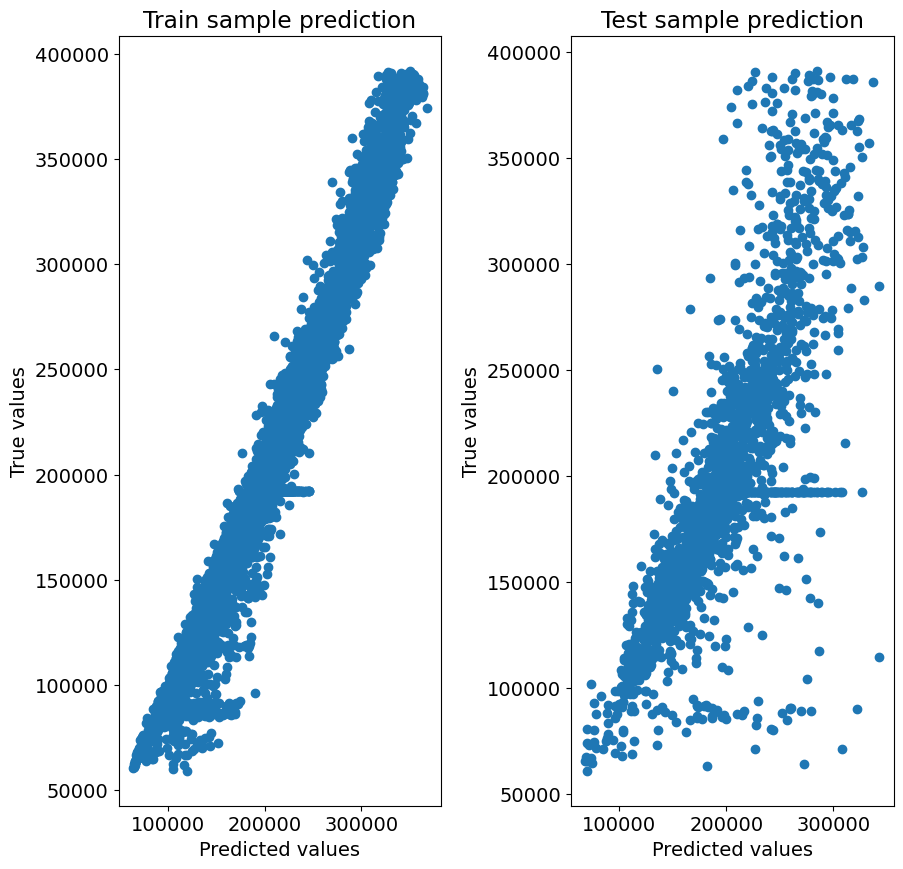

In [101]:
# Let's make a prediction based on a training and valid sample. And also read the r2 metrics.
y_train_preds = rf_model.predict(X_train_scaled)
y_valid_preds = rf_model.predict(X_valid_scaled)

evalute_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [102]:
# Let's check the quality of the model for cross validation
cv_score = cross_val_score(rf_model, X_train_scaled, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=123))
cv_score

array([0.57882536, 0.58444078, 0.59120116])

In [103]:
# The average number of cross validation
cv_score.mean()

0.5848224329267788

In [104]:
# The most influential features on the model
feature_impotancer = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'impotance'])
feature_impotancer.sort_values(by='impotance', ascending=False)

,feature_name,impotance
2,Square,0.183280
3,LifeSquare,0.110760
1,Rooms,0.107772
12,Social_2,0.069411
11,Social_1,0.068361
0,DistrictId,0.066762
7,HouseYear,0.066535
13,Social_3,0.053556
4,KitchenSquare,0.048887
5,Floor,0.047674


In [105]:
# Let's predict the cost of apartments on a test sample
predictions = rf_model.predict(X_test_scaled)
predictions = pd.DataFrame(predictions)
predictions

,0
0,166263.733346
1,209405.212549
2,203670.588874
3,247957.785219
4,136678.044772
...,...
4995,252057.255001
4996,124313.089999
4997,311275.745043
4998,186443.849724


In [106]:
# # Let's create an instance of linear regression
# lr = LinearRegression()

In [107]:
# # Let's train a linear regression model
# lr.fit(X_train, y_train)

In [108]:
# # Сделаем предсказание линейной модели
# y_pred = lr.predict(X_valid)

In [109]:
# # Let's check the R2 metric
# r2 = r2_score(y_valid, y_pred)
# r2

В процессе исследования было выявлено что для метрики R2 больше подходит алгоритм RandomForestRegressor, чем LinearRegression.

In [111]:
submit = predictions.to_csv('rf_final_1.csv', index=False)

In [112]:
with open('rf_final_model', 'wb') as file:
    pickle.dump(rf_model, file)

In [113]:
with open('preprocessor_model', 'wb') as file:
    pickle.dump(preprocessor, file)